# Methods
Note: Each section has a corresponding discussion in the attached memo `VinTang_report.pdf`.

# Section 2.1: Identifying "Top Selling" Items
We define top selling items as items which had the greatest total sales over this week across all countries.

## Preparing data
Data (totalling 541,909 records) was provided as `Online Retail.csv` and was prepared for further analysis.

In [1]:
from util import make_predictions

from fbprophet import Prophet

import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("ggplot")
%matplotlib inline

In [2]:
df = pd.read_csv("data/Online Retail.csv", encoding = "ISO-8859-1")
df.shape

(541909, 8)

In [3]:
# remove cancelled invoices, which are invoices where InvoiceNo starts with the letter "C"
df['cancelled'] = df.apply(lambda row: str(row.InvoiceNo)[0] == "C", axis=1) 
print("number of cancelled invoices: ", np.sum(df['cancelled']))

df = df[df['cancelled'] == False]

number of cancelled invoices:  9288


In [4]:
# create a "revenue" column so we can identify best selling items for a given range
df['revenue'] = df.apply(lambda row: row.Quantity * row.UnitPrice, axis=1) 

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancelled,revenue,datestring,datetime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom,False,15.30,12/1/10,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom,False,20.34,12/1/10,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom,False,22.00,12/1/10,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom,False,20.34,12/1/10,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom,False,20.34,12/1/10,2010-12-01


In [40]:
# create a date column so we can identify best selling items for a given range
df["datestring"] = df.apply(lambda row: row.InvoiceDate.split(" ")[0], axis=1) 
df['datetime'] = pd.to_datetime(df['datestring'])

In [9]:
# define list of attributes required    
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']

# define generator expression of series, one for each attribute
date_gen = (getattr(df['datetime'].dt, i).rename(i) for i in L)

# concatenate results and join to original dataframe
df = df.join(pd.concat(date_gen, axis=1))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cancelled,revenue,datestring,datetime,timestamp,year,month,day,dayofweek,dayofyear,weekofyear,quarter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom,False,15.30,12/1/10,2010-12-01,1.291180e+09,2010,12,1,2,335,48,4
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom,False,20.34,12/1/10,2010-12-01,1.291180e+09,2010,12,1,2,335,48,4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom,False,22.00,12/1/10,2010-12-01,1.291180e+09,2010,12,1,2,335,48,4
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom,False,20.34,12/1/10,2010-12-01,1.291180e+09,2010,12,1,2,335,48,4
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom,False,20.34,12/1/10,2010-12-01,1.291180e+09,2010,12,1,2,335,48,4


In [41]:
df['mm-yyyy'] = pd.to_datetime(df['datestring']).dt.strftime('%m-%Y')

## Identifying Best Selling Items in the desired time period
Note: Stockcode ID "DOT" refers to postage and not considered inventory.

In [45]:
# we want best selling items for the period between 11/27/11 and 12/3/11

start = "11/27/11"
end = "12/3/11"

select = (df['datetime'] >= "11/27/11") & (df['datetime'] <= "12/3/11")
df_small = df[select]

Text(0, 0.5, 'Revenue')

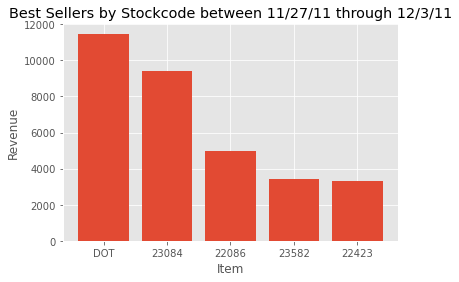

In [49]:
qty = df_small.groupby("StockCode")['revenue'].sum().sort_values(ascending=False)[:5]

plt.bar(list(qty.index), list(qty.values))
plt.title("Best Sellers by Stockcode between 11/27/11 through 12/3/11")
plt.xlabel("Item")
plt.ylabel("Revenue")

In [47]:
# return a list of best sellers by stock id over that period
best_sellers = list(df_small.groupby("StockCode")['Quantity'].sum().sort_values(ascending=False)[:3].index)
best_sellers

['23084', '22197', '23582']

## A Closer Look at Best Selling Items
Let's take a closer look at the three best selling items: 23084, 22197, 23582.

### Historical Sales for Item 23084

Text(0, 0.5, 'Quantity')

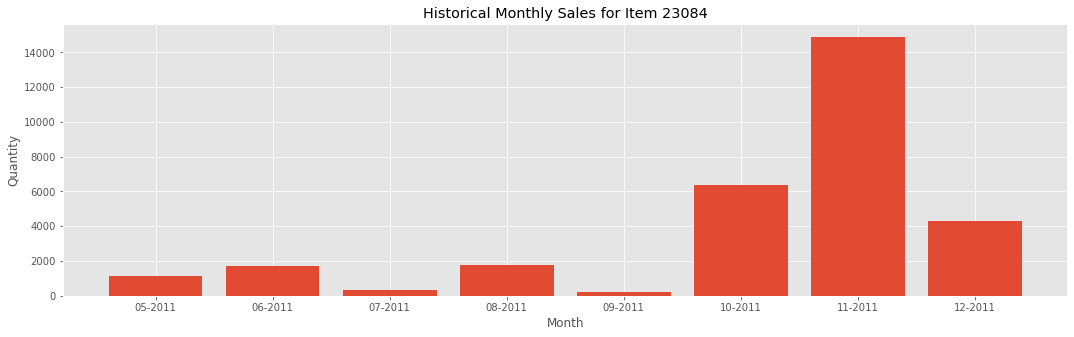

In [49]:
df_23084 = df[df['StockCode'] == '23084']
monthly_23084 = df_23084.groupby("mm-yyyy")['Quantity'].sum()

f, ax = plt.subplots(figsize=(18,5))
plt.bar(list(monthly_23084.index), list(monthly_23084.values))

plt.title("Historical Monthly Sales for Item 23084")
plt.xlabel("Month")
plt.ylabel("Quantity")

Text(0, 0.5, 'Quantity')

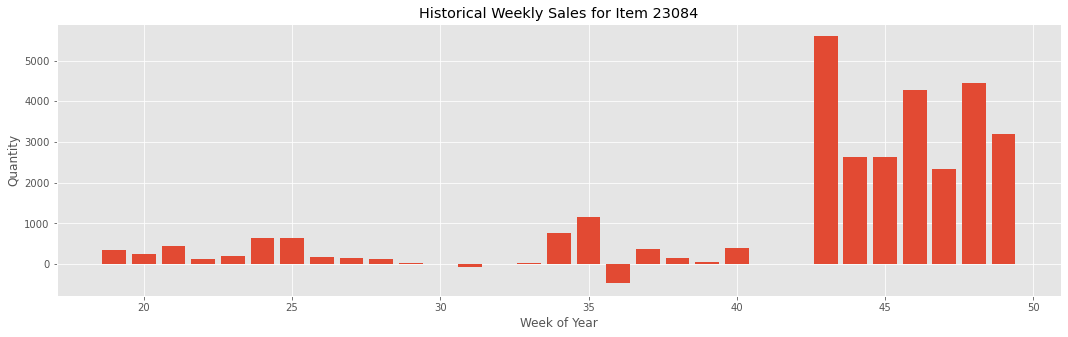

In [173]:
df_23084 = df[df['StockCode'] == '23084']
monthly_23084 = df_23084.groupby("weekofyear")['Quantity'].sum()

f, ax = plt.subplots(figsize=(18,5))
plt.bar(list(monthly_23084.index), list(monthly_23084.values))

plt.title("Historical Weekly Sales for Item 23084")
plt.xlabel("Week of Year")
plt.ylabel("Quantity")

### Historical Sales for Item 22197
There seems to be a quaterly and monthly cycle for item 22197.

Text(0, 0.5, 'Quantity')

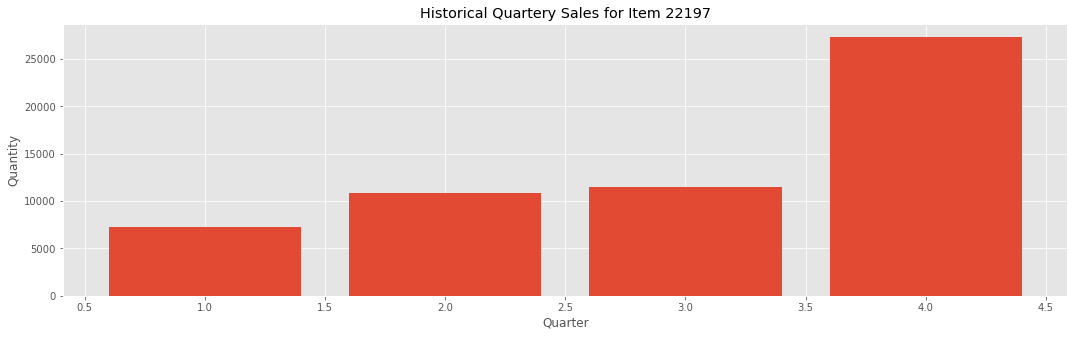

In [36]:
df_22197 = df[df['StockCode'] == '22197']
monthly_22197 = df_22197.groupby("quarter")['Quantity'].sum()

f, ax = plt.subplots(figsize=(18,5))
plt.bar(list(monthly_22197.index), list(monthly_22197.values))

plt.title("Historical Quartery Sales for Item 22197")
plt.xlabel("Quarter")
plt.ylabel("Quantity")

Text(0, 0.5, 'Quantity')

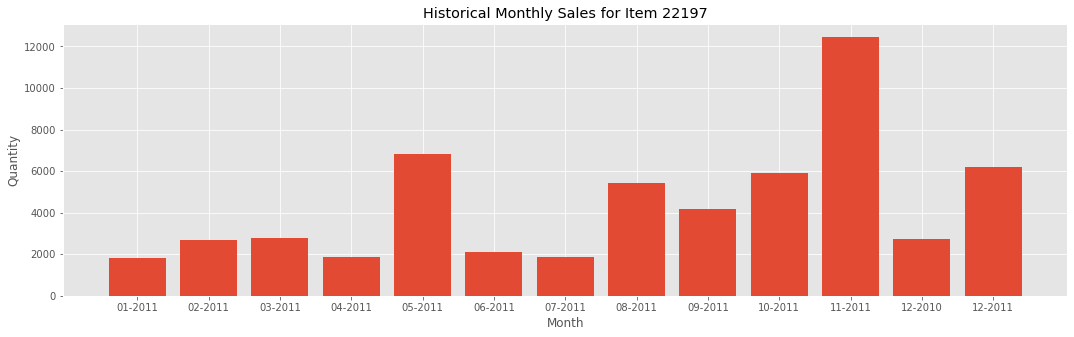

In [44]:
df_22197 = df[df['StockCode'] == '22197']
monthly_22197 = df_22197.groupby("mm-yyyy")['Quantity'].sum()

f, ax = plt.subplots(figsize=(18,5))
plt.bar(list(monthly_22197.index), list(monthly_22197.values))

plt.title("Historical Monthly Sales for Item 22197")
plt.xlabel("Month")
plt.ylabel("Quantity")

Text(0, 0.5, 'Quantity')

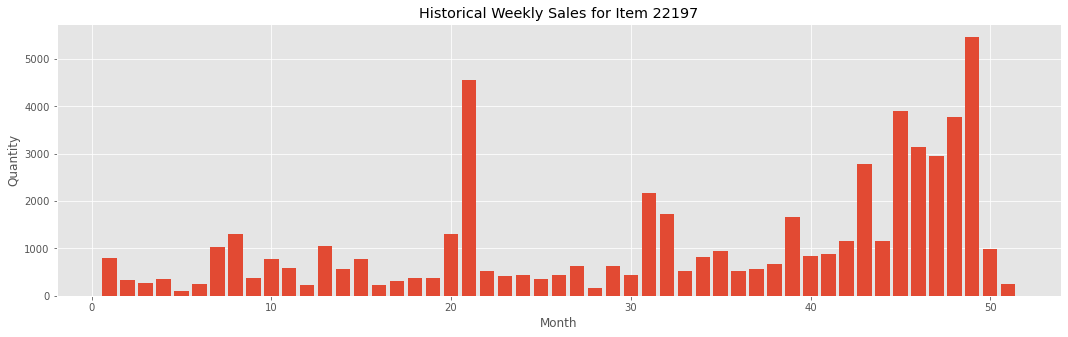

In [13]:
df_22197 = df[df['StockCode'] == '22197']
monthly_22197 = df_22197.groupby("weekofyear")['Quantity'].sum()

f, ax = plt.subplots(figsize=(18,5))
plt.bar(list(monthly_22197.index), list(monthly_22197.values))

plt.title("Historical Weekly Sales for Item 22197")
plt.xlabel("Month")
plt.ylabel("Quantity")

### Historical Sales for Item 23582

Text(0, 0.5, 'Quantity')

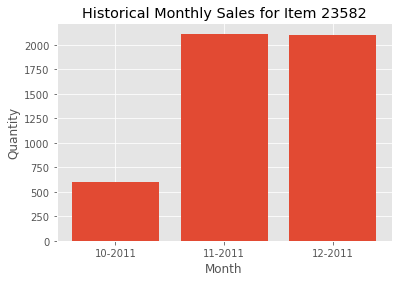

In [52]:
df_23582 = df[df['StockCode'] == '23582']
weekly_23582 = df_23582.groupby("mm-yyyy")['Quantity'].sum()

plt.bar(weekly_23582.index, weekly_23582.values)
plt.title("Historical Monthly Sales for Item 23582")
plt.xlabel("Month")
plt.ylabel("Quantity")

Text(0, 0.5, 'Quantity')

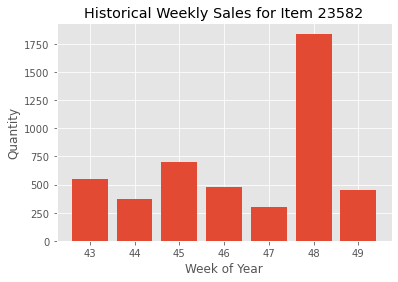

In [190]:
df_23582 = df[df['StockCode'] == '23582']
weekly_23582 = df_23582.groupby("weekofyear")['Quantity'].sum()

plt.bar(weekly_23582.index, weekly_23582.values)
plt.title("Historical Weekly Sales for Item 23582")
plt.xlabel("Week of Year")
plt.ylabel("Quantity")

Text(0, 0.5, 'Quantity')

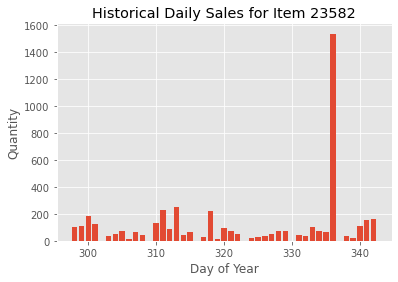

In [228]:
df_23582 = df[df['StockCode'] == '23582']
weekly_23582 = df_23582.groupby("dayofyear")['Quantity'].sum()

plt.bar(weekly_23582.index, weekly_23582.values)
plt.title("Historical Daily Sales for Item 23582")
plt.xlabel("Day of Year")
plt.ylabel("Quantity")

# Section 2.2 - Forecasting
From the provided dataset of historical data, we removed anything beyond the cutoff date of 11/27/11.

Build a model that predicts sales quantities for the 7 days from 11/27/2011 - 12/3/2011.

In [134]:
test_period = ['11/27/11', '11/28/11', '11/29/11', '11/30/11', '12/1/11', '12/2/11']
train_df = df[df['datetime'] < "11/27/11"]
train_base = train_df.sort_values('timestamp')

## Forecasting Item 23582
When we break out item 23582, we see that UK accounts for the majority of sales.

For our time series prediction, we detect weekly cycles not not yearly or seasonal cycles.

In [147]:
train_df = train_base[train_base['StockCode'] == '23582']
train_df.shape

(193, 21)

Text(0, 0.5, 'Quantity')

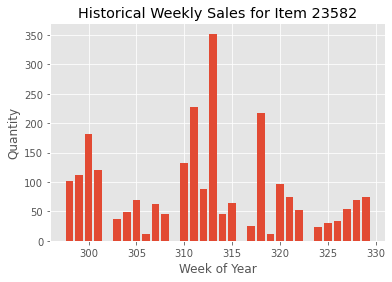

In [148]:
weekly_23582 = train_df.groupby("dayofyear")['Quantity'].sum()

plt.bar(weekly_23582.index, weekly_23582.values)
plt.title("Historical Weekly Sales for Item 23582")
plt.xlabel("Week of Year")
plt.ylabel("Quantity")

In [149]:
p = pd.pivot_table(train_df, index=['datetime'], columns= ['Country'], values='Quantity', aggfunc='sum')
p.head()

Country,Channel Islands,Finland,France,Germany,Italy,Netherlands,Portugal,United Kingdom
datetime,,,,,,,,
2011-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0
2011-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0
2011-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.0
2011-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.0
2011-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0


In [150]:
data = {'Date': test_period}

for country in p.columns:
    try:
        x = pd.DataFrame({"ds": p.index, "y": p[country].values})            
        model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
        model.fit(x)
        pred = model.predict(pd.DataFrame({"ds":test_period}))
        data[country] = pred['yhat'].values
    except:
        data[country] = [0] * len(test_period)
pd.DataFrame(data).to_csv("./results/23582.csv")

INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


## Item 22197
When we break out item 22197, we see there are weekly and seasonal trends, and fit our predictive model accordingly.

In [137]:
train_df = train_base[train_base['StockCode'] == '22197']
train_df.shape

(1305, 21)

In [139]:
p = pd.pivot_table(train_df, index=['datetime'], columns= ['Country'], values='Quantity', aggfunc='sum')
p.head()

Country,Belgium,Channel Islands,Cyprus,EIRE,France,Germany,Israel,Italy,Netherlands,Norway,Singapore,Spain,Switzerland,United Kingdom,Unspecified
datetime,,,,,,,,,,,,,,,
2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN,199.0,NaN
2010-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,NaN
2010-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,NaN
2010-12-05,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,NaN
2010-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.0,NaN


In [140]:
data = {'Date': test_period}

for country in p.columns:
    try:
        x = pd.DataFrame({"ds": p.index, "y": p[country].values})            
        model = Prophet(yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=False)
        model.fit(x)
        pred = model.predict(pd.DataFrame({"ds":test_period}))
        data[country] = pred['yhat'].values
    except:
        data[country] = [0] * len(test_period)
pd.DataFrame(data).to_csv("./results/22197.csv")

INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


## Item 23804
When we break out item 23804, we see there are weekly and seasonal trends, and fit our predictive model accordingly.

In [106]:
train_df = train_base[train_base['StockCode'] == '23084']
train_df.shape

(834, 21)

In [107]:
p = pd.pivot_table(train_df, index=['datetime'], columns= ['Country'], values='Quantity', aggfunc='sum')
p.tail()

Country,Australia,Belgium,Denmark,EIRE,Finland,France,Germany,Iceland,Italy,Japan,Netherlands,Norway,Poland,Portugal,Spain,Sweden,Switzerland,United Kingdom,Unspecified
datetime,,,,,,,,,,,,,,,,,,,
2011-11-21,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,95.0,NaN
2011-11-22,NaN,NaN,NaN,6.0,NaN,84.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,493.0,NaN
2011-11-23,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,395.0,NaN
2011-11-24,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.0,12.0
2011-11-25,NaN,NaN,NaN,NaN,NaN,174.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371.0,NaN


In [115]:
data = {'Date': test_period}

for country in p.columns:
    try:
        x = pd.DataFrame({"ds": p.index, "y": p[country].values})            
        model = Prophet(yearly_seasonality=False, daily_seasonality=True, weekly_seasonality=False)
        model.fit(x)
        pred = model.predict(pd.DataFrame({"ds":test_period}))
        data[country] = pred['yhat'].values
    except:
        data[country] = [0] * len(test_period)
pd.DataFrame(data).to_csv("./results/23084.csv")

INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 0.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprop

# Part 3: Comparing with Out of Sample 

In [130]:
select = (df['datetime'] >= "11/27/11") & (df['datetime'] <= "12/3/11")

test_df = df[select]

### Evaluating Forecast for Item 23084

In [131]:
test_df_stockcode = test_df[test_df['StockCode'] == '23084'].groupby('datetime')['Quantity'].sum()
test_df_stockcode

datetime
2011-11-27     317
2011-11-28     381
2011-11-29    2565
2011-11-30     408
2011-12-01     593
2011-12-02     325
Name: Quantity, dtype: int64

In [132]:
pred23084 = pd.read_csv("results/23084.csv").drop(['Unnamed: 0'], axis=1).sum(axis=1)
pred23084

0    3259.029853
1    3273.379789
2    3287.729724
3    3302.079660
4    3316.429595
5    3330.779531
6    3345.129466
dtype: float64

### Evaluating Forecast for Item 22197

In [143]:
test_df_stockcode = test_df[test_df['StockCode'] == '22197'].groupby('datetime')['Quantity'].sum()
test_df_stockcode

datetime
2011-11-27      41
2011-11-28      32
2011-11-29     105
2011-11-30      72
2011-12-01      67
2011-12-02    1534
Name: Quantity, dtype: int64

In [144]:
pred23084 = pd.read_csv("results/22197.csv").drop(['Unnamed: 0'], axis=1).sum(axis=1)
pred23084

0    -886.784887
1   -1033.976095
2   -1196.865489
3   -1371.197387
4   -1552.260164
5   -1734.994797
dtype: float64

### Evaluating Forecast for Item 23582

In [145]:
test_df_stockcode = test_df[test_df['StockCode'] == '23582'].groupby('datetime')['Quantity'].sum()
test_df_stockcode

datetime
2011-11-27      41
2011-11-28      32
2011-11-29     105
2011-11-30      72
2011-12-01      67
2011-12-02    1534
Name: Quantity, dtype: int64

In [151]:
pred23084 = pd.read_csv("results/23582.csv").drop(['Unnamed: 0'], axis=1).sum(axis=1)
pred23084

0   -291.623421
1    338.560982
2    199.536873
3    332.973723
4    419.051556
5    397.751063
dtype: float64